## POOL WBTC_DAI 
**Pool Characteristics: Low capitalization, low transaction frequency**
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [11]:
EXPERIMENT_ID = 53

X_NAME = 'WBTC'
Y_NAME = 'DAI'

WINDOW_SIZE = 24 * 60 * 60

In [12]:
BASE_DIR = fr'..\..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [13]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [14]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [15]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [16]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,3,WBTC,DAI,0.000039,0.0,0.375990,0.001504,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,9267.0,2020-05-20 11:55:41,2020-05-20 11:55:36,0x337e7bf5b2b4c385597b11dffcf70d0cddac162d4772...,3,0.015897,156.421121,2.486587,0,0,False,0.015935,156.043627,2.486624,0,0,False,9792.238395,-0.004835
1,4,WBTC,DAI,0.000017,0.0,0.161727,0.000647,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,10862.0,2020-05-20 18:34:26,2020-05-20 18:34:15,0xd36f3e8bc306eb4c2ff894d1a8932c4647913af9d322...,4,0.015935,156.043627,2.486624,0,0,False,0.015952,155.881253,2.486640,234279303,2,False,9771.808248,-0.002086
2,5,WBTC,DAI,0.000256,0.0,2.433899,0.009736,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,18053.0,2020-05-22 00:32:11,2020-05-22 00:32:08,0xf3eaa95adf2319acf5b57db3f345b4a3f607bba4a833...,5,0.015952,155.881253,2.486640,234279303,2,False,0.016208,153.437619,2.486874,1288315400,13,False,9466.946544,-0.031198
3,6,WBTC,DAI,0.000022,0.0,0.207315,0.000829,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,20436.0,2020-05-22 10:27:56,2020-05-22 10:27:44,0x5c08ee19949610beb1c54ae00eb576564a26a26cb029...,6,0.016208,153.437619,2.486874,1288315400,13,False,0.016230,153.229474,2.486894,1626711404,17,False,9441.201571,-0.002719
4,7,WBTC,DAI,0.000022,0.0,0.206752,0.000827,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,20447.0,2020-05-22 10:30:41,2020-05-22 10:30:29,0xb27b3c99425963ec06978be76fb6c47ce34eaf3fbb16...,7,0.016230,153.229474,2.486894,1626711404,17,False,0.016252,153.021895,2.486915,1628269202,17,False,9415.561578,-0.002716


In [17]:
swaps0_df.status.value_counts()

SUCCESS    13872
Name: status, dtype: int64

In [18]:
swaps1_df.status.value_counts()

SUCCESS                             13869
BLOCKED_BY_VOLATILITY_MITIGATION        3
Name: status, dtype: int64

In [19]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.00021626297577854672


In [20]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                9168
CANT_CONSULT_ORACLE    4704
Name: mitigator_check_status, dtype: int64

In [59]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.3391003460207612


In [60]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    138
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    138
Name: status, dtype: int64


**Only 3 out of 13 872** have been **blocked by the volatility mitigation mechanism**. During about **33%** of the cases volatility mitigation mechanism didn't check the transaction as TWAP coudn't be computed

### Table of transactions blocked by Volatility Mitigation Mechanism

In [61]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before']]

,token_in,token_out,token_in_amount,token_out_amount,slice_factor,oracle_amount_out,out_amount_diff,reserve_Y_before,reserve_Y_before
4017,DAI,WBTC,4000.000000,0.096852,37.0,0.134965,32.0,10829.600689,10829.600689
13151,DAI,WBTC,152135.514321,2.853247,28.0,3.795402,28.0,546180.486138,546180.486138
13153,WBTC,DAI,4.872345,143681.055827,37.0,195377.007969,30.0,540804.943638,540804.943638


Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

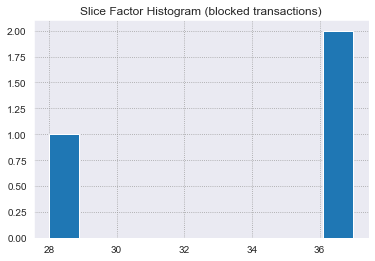

In [62]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

**The 3 blocked transactions have a slice factor between 28 and 37**

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

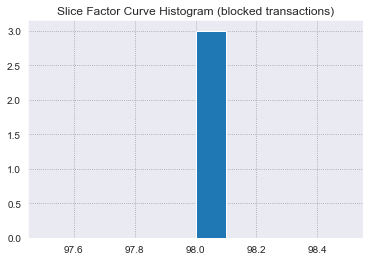

In [29]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

In [63]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)').update_xaxes(categoryorder='total descending')
fig.show()

Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which weren't checked therefore by volatility mitigation mechanism

**It can be seen that all of the swaps with a slice_factor greater than 20 have been blocked**

In [31]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor > 1], x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram').update_xaxes(categoryorder='total descending')
fig.show()

**The blocked transactions have a  price difference with the one from oracle greater than 25%**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

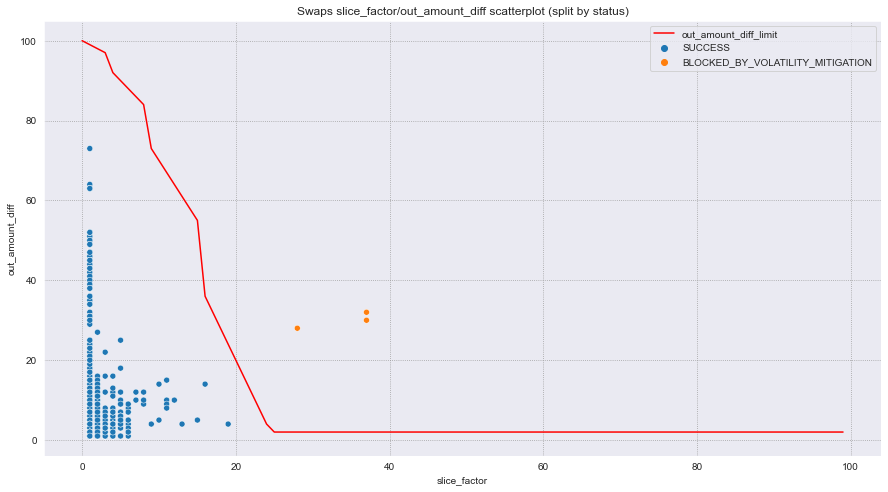

In [32]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

**Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which represent a very big proportion of all of the transactions (about 33%)**

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

The border seems to separete the successful and blocked transactions pretty good. It can be observed that by varying the PRICE_TOLLERANCE_TRESHOLD by an amount less than 20, no effect would be obtained. It would require to decrease this number by more than 20 in order to change the distribution of successful/blocked transaction

Text(0, 0.5, 'Count')

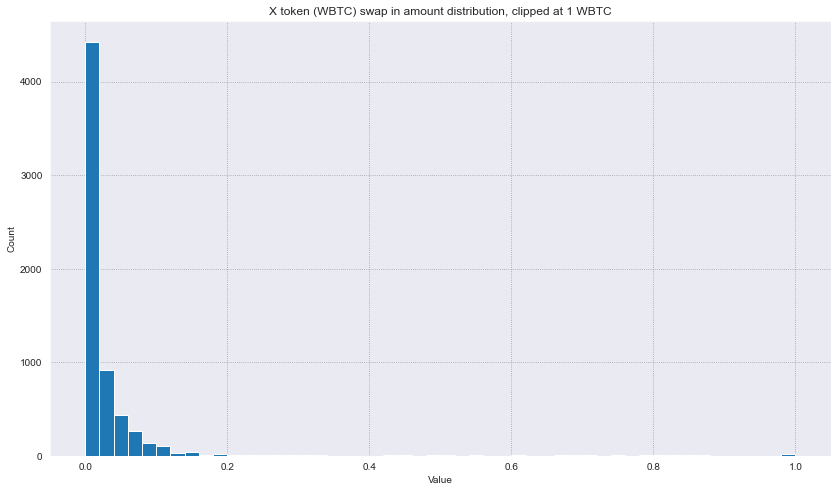

In [36]:
UPPER_LIMIT = 1

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

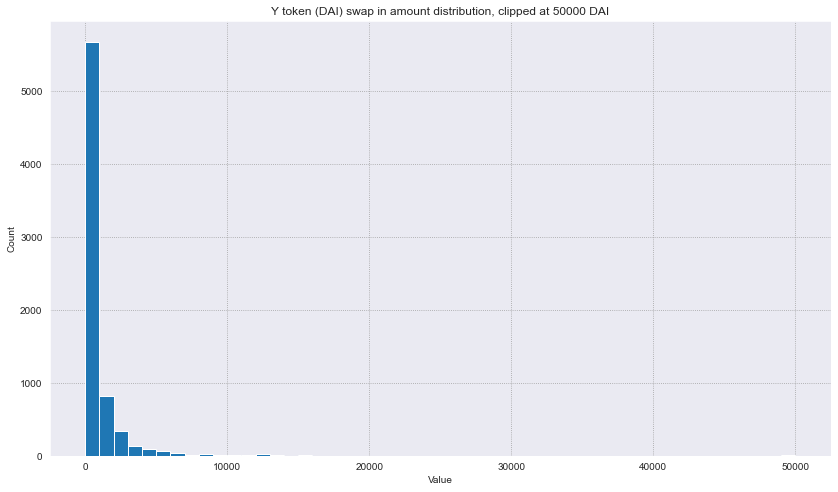

In [37]:
UPPER_LIMIT = 50000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

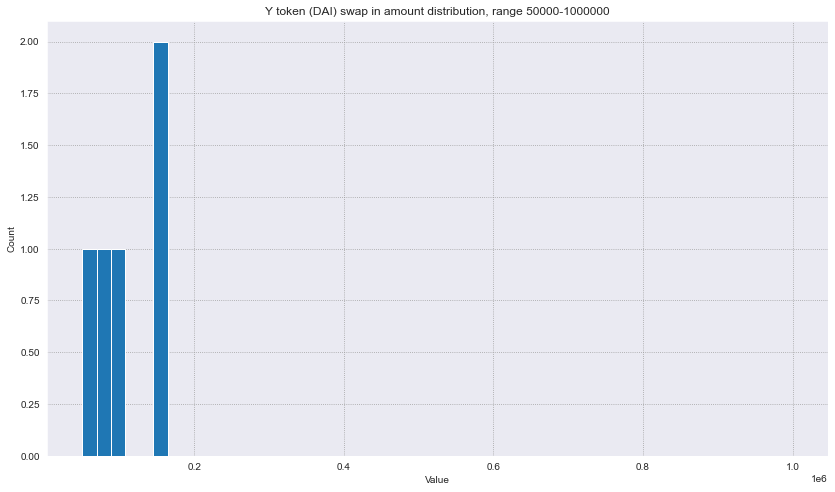

In [38]:
LOWER_LIMIT = 50000
UPPER_LIMIT = 1000000
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

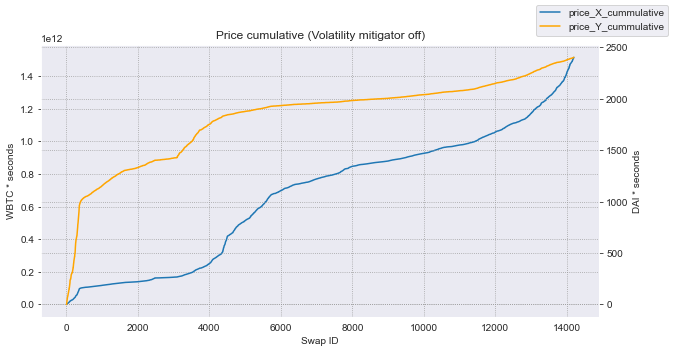

In [39]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

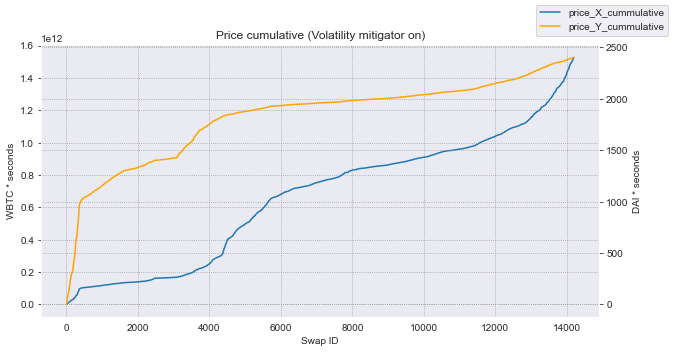

In [40]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

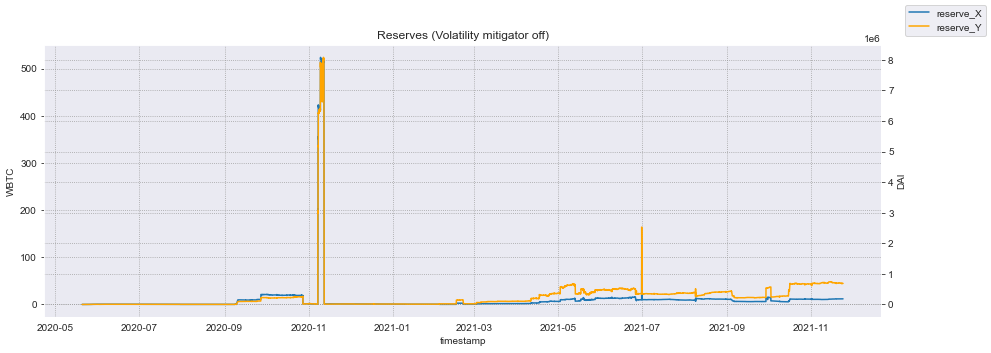

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

The spike in the reserves near 2021.07 is caused due to a liqiudity provision and extraction one hour later.

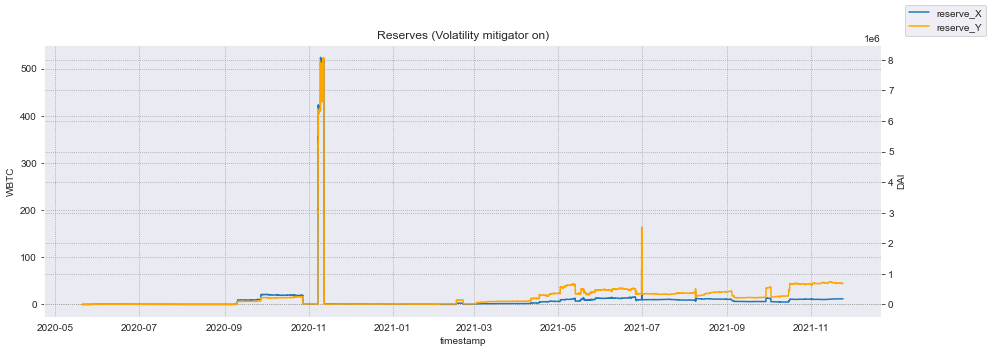

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

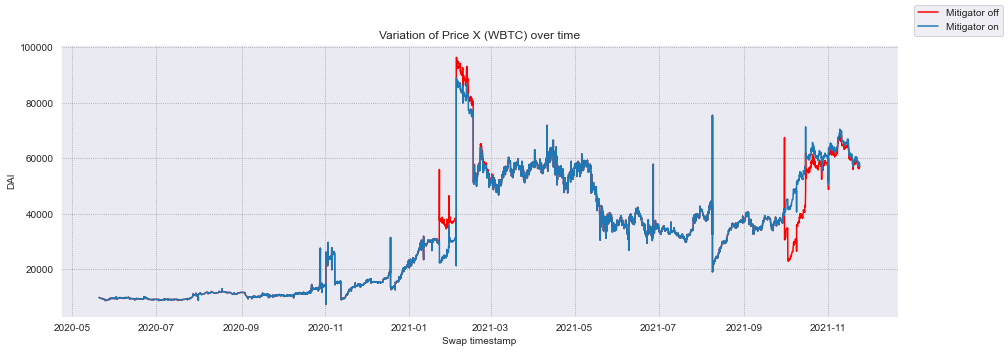

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**It can be seen from the variation of price that the volatility mitigation mechanism slightly decreases the price variation in several cases.
The sudden price increase in 02.03 is caused by a single transaction whose swap_in value is much bigger than the current reserves.**

In [50]:
swaps1_df[swaps1_df.X_price > 60000].iloc[0].to_frame().T

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
4219,4375,DAI,WBTC,10000.0,0.0,0.228706,40.0,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1503807.0,2021-02-03 23:10:41,2021-02-03 23:10:39,0x2bce76806ce9e5e303b2408823006cd3052213aa1af3...,4375,0.447521,9471.849558,4238.849109,314030287114,1832,True,0.218815,19431.849558,4251.978002,314030287114,1832,True,88804.969598,3.195808


It can be seen that the volatility mitigator didn’t check this transaction, as there were no swaps happening in the 1 hour window exactly 24 hours ago, even though during the entire 24 hour window_size period more than 10 swaps happened.

In [54]:
swaps1_df.iloc[4219-11:4219+1]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
4208,4363,DAI,WBTC,23.169225,0.0,0.000748,0.092677,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1497606.0,2021-02-02 21:20:26,2021-02-02 21:20:12,0xd7e5a8d9f3c2378683f6352f5d464cc12e011d4233ec...,4363,0.367494,11242.445654,4131.527728,310821843573,1829,True,0.366745,11265.522202,4131.578711,311144438479,1829,True,30717.553593,0.004097
4209,4365,DAI,WBTC,12.259807,0.0,0.000394,0.049039,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1499021.0,2021-02-03 03:14:11,2021-02-03 03:14:03,0xcee9bb3776049d267428086cad80c2d01f1f3d7c1d3c...,4365,0.370942,11415.522202,4234.494508,311144438479,1829,True,0.370548,11427.732970,4234.521765,311797625718,1830,True,30840.101451,0.002134
4210,4366,DAI,WBTC,101.080406,0.0,0.003217,0.404322,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1499310.0,2021-02-03 04:26:26,2021-02-03 04:26:15,0x20604333d89f3c3f9d08d9382b50b31a8f31aebfbb78...,4366,0.370548,11427.732970,4234.521765,311797625718,1830,True,0.367331,11528.409055,4234.744545,311931317558,1830,True,31384.234378,0.017644
4211,4367,WBTC,DAI,0.000297,0.0,9.222077,0.036888,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1499349.0,2021-02-03 04:36:11,2021-02-03 04:36:03,0x40f61796354cb29bff689a8b7c0fc394e2316b3b8b38...,4367,0.367331,11528.409055,4234.744545,311931317558,1830,True,0.367628,11519.150090,4234.765202,311949677335,1830,True,31333.689701,-0.001611
4212,4368,WBTC,DAI,0.001544,0.0,47.701412,0.190806,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1499363.0,2021-02-03 04:39:41,2021-02-03 04:39:35,0x185c191c6843b5c65116655d029c567d1ddda75b8403...,4368,0.367628,11519.150090,4234.765202,311949677335,1830,True,0.369172,11471.257872,4234.871897,311956257409,1830,True,31072.901465,-0.008323
4213,4369,WBTC,DAI,0.000043,0.0,1.315547,0.005262,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1500607.0,2021-02-03 09:50:41,2021-02-03 09:50:32,0x7b18a7569b6ea40677e66c4dcc21bf6dc2a0c35dc04e...,4369,0.369172,11471.257872,4234.871897,311956257409,1830,True,0.369215,11469.937062,4234.874860,312536077751,1831,True,31065.724627,-0.000231
4214,4370,WBTC,DAI,0.000043,0.0,1.313706,0.005255,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1500865.0,2021-02-03 10:55:11,2021-02-03 10:55:02,0x1d9ae77c9d6afcf695230a099bcef5bcc36ce8edd20f...,4370,0.369215,11469.937062,4234.874860,312536077751,1831,True,0.369258,11468.618102,4234.877819,312656302105,1831,True,31058.558663,-0.000231
4215,4371,WBTC,DAI,0.000021,0.0,0.656432,0.002626,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1500878.0,2021-02-03 10:58:26,2021-02-03 10:58:20,0xb366ba7f6f65386cab8ff80225311ad00c986965bf71...,4371,0.369258,11468.618102,4234.877819,312656302105,1831,True,0.369279,11467.959044,4234.879297,312662358524,1831,True,31054.978290,-0.000115
4216,4372,DAI,WBTC,15.976918,0.0,0.000509,0.063908,CHECKED,0.000517,1.0,1.0,1.0,SUCCESS,1502292.0,2021-02-03 16:51:56,2021-02-03 16:51:46,0x115ccb0ea5f27783101ed5b9e18f7534eae05c0b35aa...,4372,0.369279,11467.959044,4234.879297,312662358524,1831,True,0.368771,11483.872054,4234.914648,313321034614,1831,True,31140.962289,0.002769
4217,4373,DAI,WBTC,16.363380,0.0,0.000519,0.065454,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1502617.0,2021-02-03 18:13:11,2021-02-03 18:13:00,0x1119aaffe03473fa15c89a73dbafbea3c0b36cb42078...,4373,0.368771,11483.872054,4234.914648,313321034614,1831,True,0.368251,11500.169980,4234.950803,313472846805,1832,True,31229.148984,0.002832


## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [22]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2020-05-20 11:00:00    1
2020-05-20 12:00:00    0
2020-05-20 13:00:00    0
2020-05-20 14:00:00    0
2020-05-20 15:00:00    0
                      ..
2021-11-23 22:00:00    0
2021-11-23 23:00:00    0
2021-11-24 00:00:00    0
2021-11-24 01:00:00    0
2021-11-24 02:00:00    1
Freq: H, Length: 13264, dtype: int64

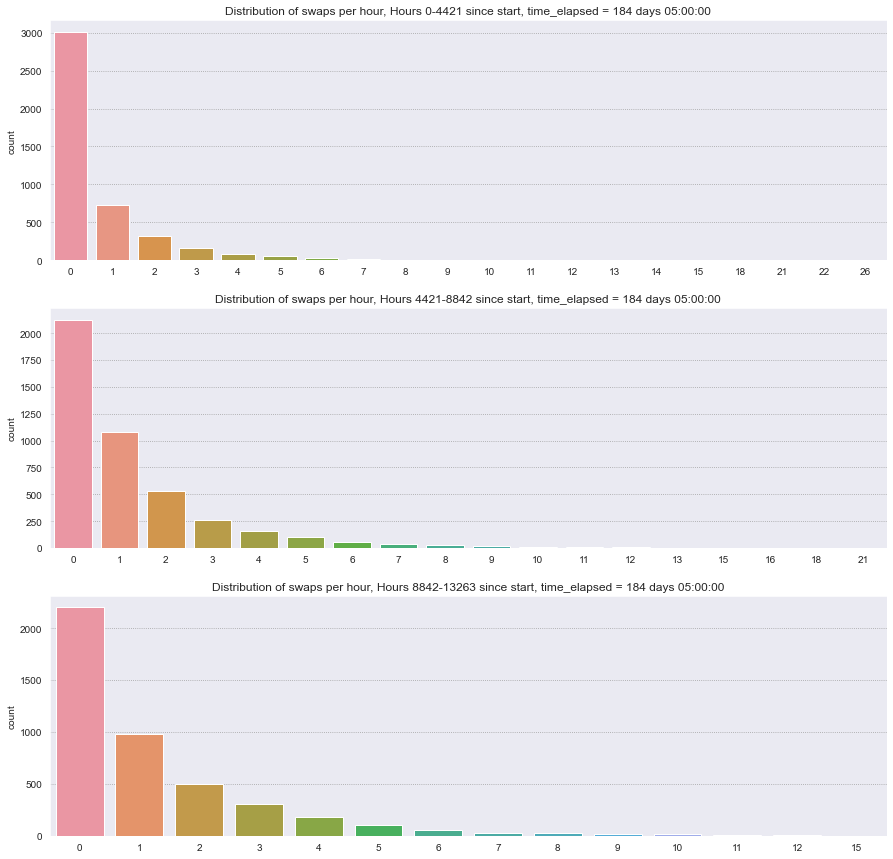

In [23]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    time_elapsed = (resampled.index[end_idx] - resampled.index[start_idx])
    
    sns.countplot(x=resampled.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per hour, Hours {start_idx}-{end_idx} since start, time_elapsed = {time_elapsed}")
   # ax.set_title('Swaps per hour distribution')

The count for x = 0 (no swaps per hour), shows how many missing periods for TWAP value exist. It can be seen that in the first period since creation, the highest number of missing TWAP values was registered (almost 3000).

## Count number of 24 hour periods with no swaps

In [24]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled24 = sim1_indexed_df.resample('24h').size()
resampled24.head()

transaction_timestamp
2020-05-20    2
2020-05-21    0
2020-05-22    5
2020-05-23    3
2020-05-24    4
Freq: 24H, dtype: int64

In [25]:
resampled24[resampled24 == 0].tail(100)

transaction_timestamp
2020-05-21    0
2020-05-26    0
2020-06-13    0
2020-06-27    0
2020-07-01    0
2020-07-15    0
2020-07-20    0
2020-08-01    0
2020-08-04    0
2020-08-08    0
2020-08-12    0
2020-08-24    0
2020-08-30    0
2020-09-02    0
2020-09-06    0
dtype: int64

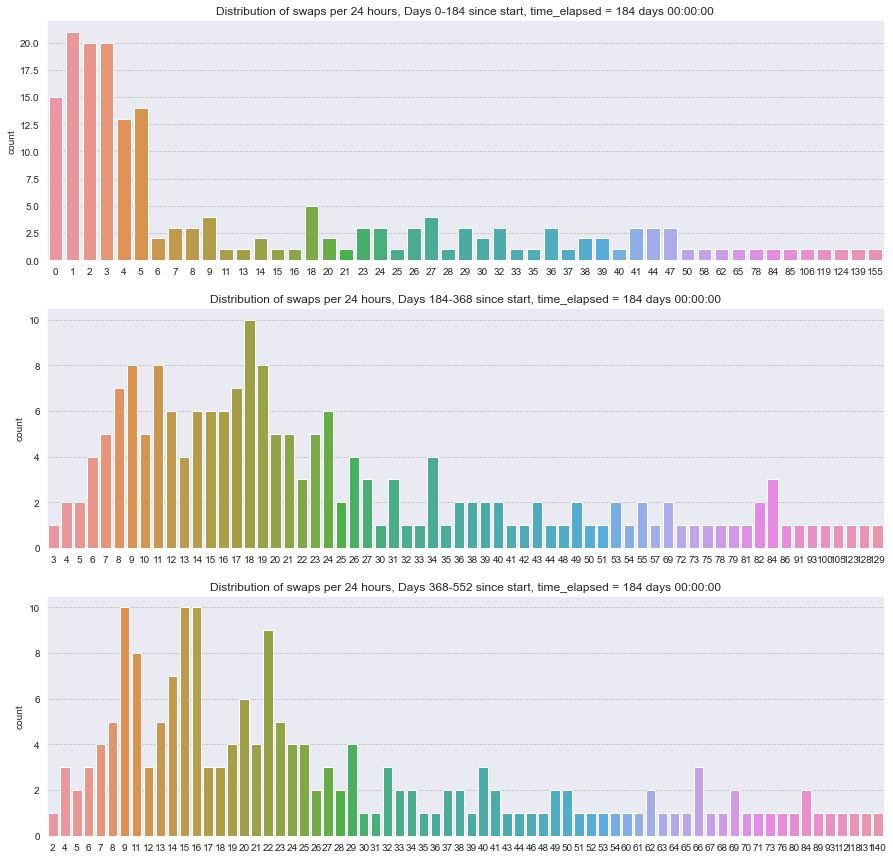

In [26]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled24)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    time_elapsed = (resampled24.index[end_idx] - resampled24.index[start_idx])
    
    sns.countplot(x=resampled24.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per 24 hours, Days {start_idx}-{end_idx} since start, time_elapsed = {time_elapsed}")
   # ax.set_title('Swaps per hour distribution')

It can be seen that in the second and last stage, there were no days with no swaps happening, the least number of swaps per day being 3 and 2 accordingly.

If the volatility mitigator mechanism would consider a more recent recorded cumulative price for computing the TWAP value, in case the one that happened exactly 24 hours ago (in the period_size window) would be missing, it would allow to perform the volatility mitigator check for each swap in the 2nd and 3rd stage of the pool development. 

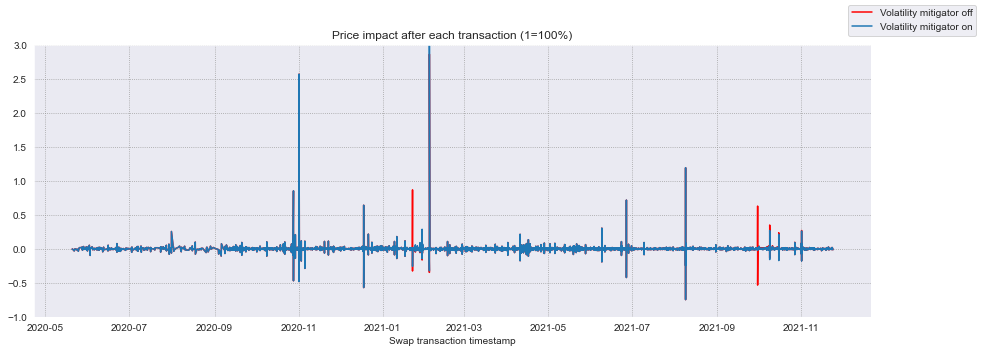

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**Most of the spikes (consecutive increases/decreases of price), are caused by MEV-bot sandwich attacks.**

**Most of the swaps with a high price impact are not bloked as the TWAP wasn't available and the volatility mitigation mechanism therefore couldn't compare the prices**

In [57]:
swaps1_df[swaps1_df.price_diff > 0.75]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
2111,2194,DAI,WBTC,5545.100861,0.0,0.271155,22.180403,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,935268.0,2020-10-28 06:15:56,2020-10-28 06:15:54,0x0c14f9be5298e482ab8e44577b088fd6e20cc09d85b1...,2194,1.023611,15233.820349,1.559351e+04,143439953478,1354,True,0.752457,20756.740807,1.561855e+04,143805837950,1356,True,27585.302396,0.853549
2233,2321,DAI,WBTC,13915.683494,0.0,1.000303,55.662734,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,958463.0,2020-11-01 06:54:41,2020-11-01 06:54:27,0x70330bc0e1f84bdbbfa7ea89f9000ac49f18d60689ee...,2321,2.127950,15530.353641,3.304782e+04,148663647637,1381,True,1.127647,29390.374401,3.314197e+04,148663647637,1381,True,26063.449316,2.571182
4219,4375,DAI,WBTC,10000.000000,0.0,0.228706,40.000000,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,1503807.0,2021-02-03 23:10:41,2021-02-03 23:10:39,0x2bce76806ce9e5e303b2408823006cd3052213aa1af3...,4375,0.447521,9471.849558,4.238849e+03,314030287114,1832,True,0.218815,19431.849558,4.251978e+03,314030287114,1832,True,88804.969598,3.195808
12199,12501,DAI,WBTC,163521.431029,0.0,3.346282,654.085724,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,2575557.0,2021-08-09 00:48:11,2021-08-09 00:47:57,0xa8d343b078a115bb78d4f118120da7ebce02bd25f1d9...,12501,10.328825,337801.021631,3.489088e+06,1094541568753,2187,True,6.982543,500668.366936,3.495939e+06,1094541568753,2187,True,71702.866046,1.192434


**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**